# Solving Bertrand Competition with Logit Demand
Logit demand on $u_j = \alpha p_i + q_i + \epsilon_{ij}$ which yields market share
$$
y_i (p_i, p_{-i}) = \frac{\exp(\alpha p_i + q_i)}{ \sum_{j=1}^N \exp(\alpha p_{j} + q_{j})}
$$
Assume constant marginal cost,$c$, so that profits are
$$
\pi_i (p_i, p_{-i}) = (p_i - c) y_i (p_i, p_{-i})
$$
The $\alpha < 0$ will be an elasticity and $q_i$ is an intrinsic quality for product $i$

The Nash-Equilibrium is a $p$ such that for for each $i$, $p_i$ is the argmaxof $\pi_i$, or 

$$
\frac{d \pi_i(p_i, p_{-i})}{d p_i} = 0
$$
For all $i$

We will solve this for a large number of agents and pretend we can't calculate the derivative directly

In [7]:
using ForwardDiff, LinearAlgebra, NLsolve, BenchmarkTools, Parameters, Statistics, Plots
using ForwardDiff: jacobian, derivative
function D_p(p, params)
    @unpack α, c, q = params
    
    # for the denominator, need to ensure it has the p[i] variable is differentiated.
    # this uses the sum for the (fixed p), removes the appropriate fixed one, and adds diff variable back
    denominator(p_i, i) = sum(exp.(α * p .+ q)) - exp(α * p[i] + q[i]) + exp(α * p_i + q[i])
    profits(p_i, i) = exp(α * p_i + q[i])*(p_i - c)/denominator(p_i, i)
    return [derivative(p_ii -> profits(p_ii, i), p[i]) for i in eachindex(p)]
end

# should we use the complementarity as well? Especially for large N
function nash_equilibrium(params; autodiff=:forward, p_iv = fill(params.c*1.5, length(params.q)))
    sol = nlsolve(p -> D_p(p, params), p_iv, autodiff = autodiff)
    markup(p, c) = p/c - 1.0
    return (p = sol.zero, markup = markup.(sol.zero, params.c), converged = converged(sol), solution = sol)
end

N = 100
NE_defaults = @with_kw (α = -1.0, c = 2.0, q = fill(5.0,N))

NE_params = NE_defaults()
@btime nash_equilibrium(NE_params);


  16.332 ms (4550 allocations: 34.80 MiB)


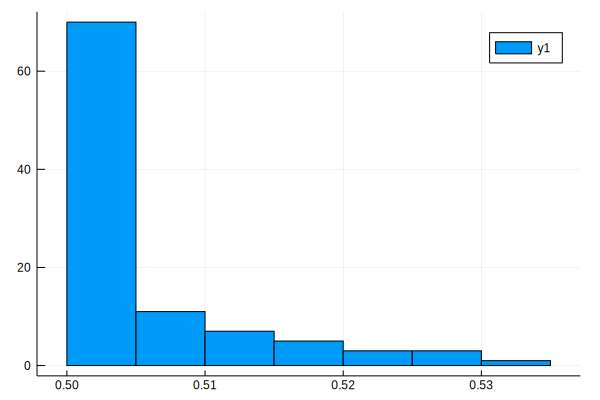

In [12]:
NE_dispersed = NE_defaults(q = range(2.0, 8.0, length=N))
sol = nash_equilibrium(NE_dispersed)
histogram(sol.markup)

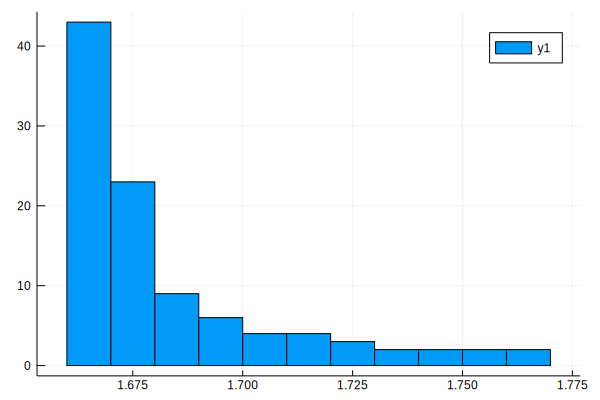

In [14]:
NE_dispersed_inelastic = NE_defaults(α = -0.3, q = range(2.0, 8.0, length=N))
sol = nash_equilibrium(NE_dispersed_inelastic)
histogram(sol.markup)

  4.145 s (304464 allocations: 6.18 GiB)


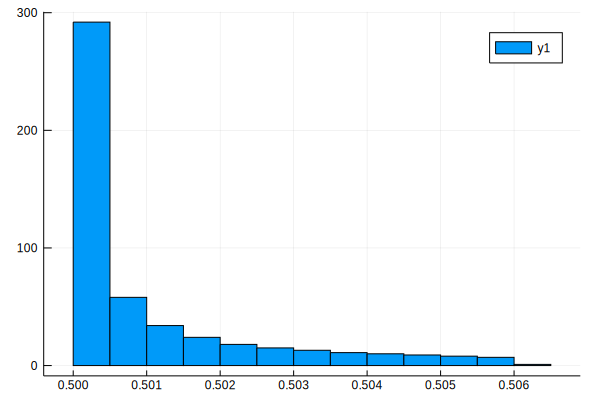

In [20]:
NE_big = NE_defaults(q = range(2.0, 8.0, length=500))
@btime nash_equilibrium(NE_big);
sol = nash_equilibrium(NE_big)
histogram(sol.markup)